In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-6-2766037100.py:21: RuntimeWarning: invalid value encountered in scalar multiply
  net_benefit = (sensitivity * prevalence) - ((1 - specificity) * (1 - prevalence) * w)


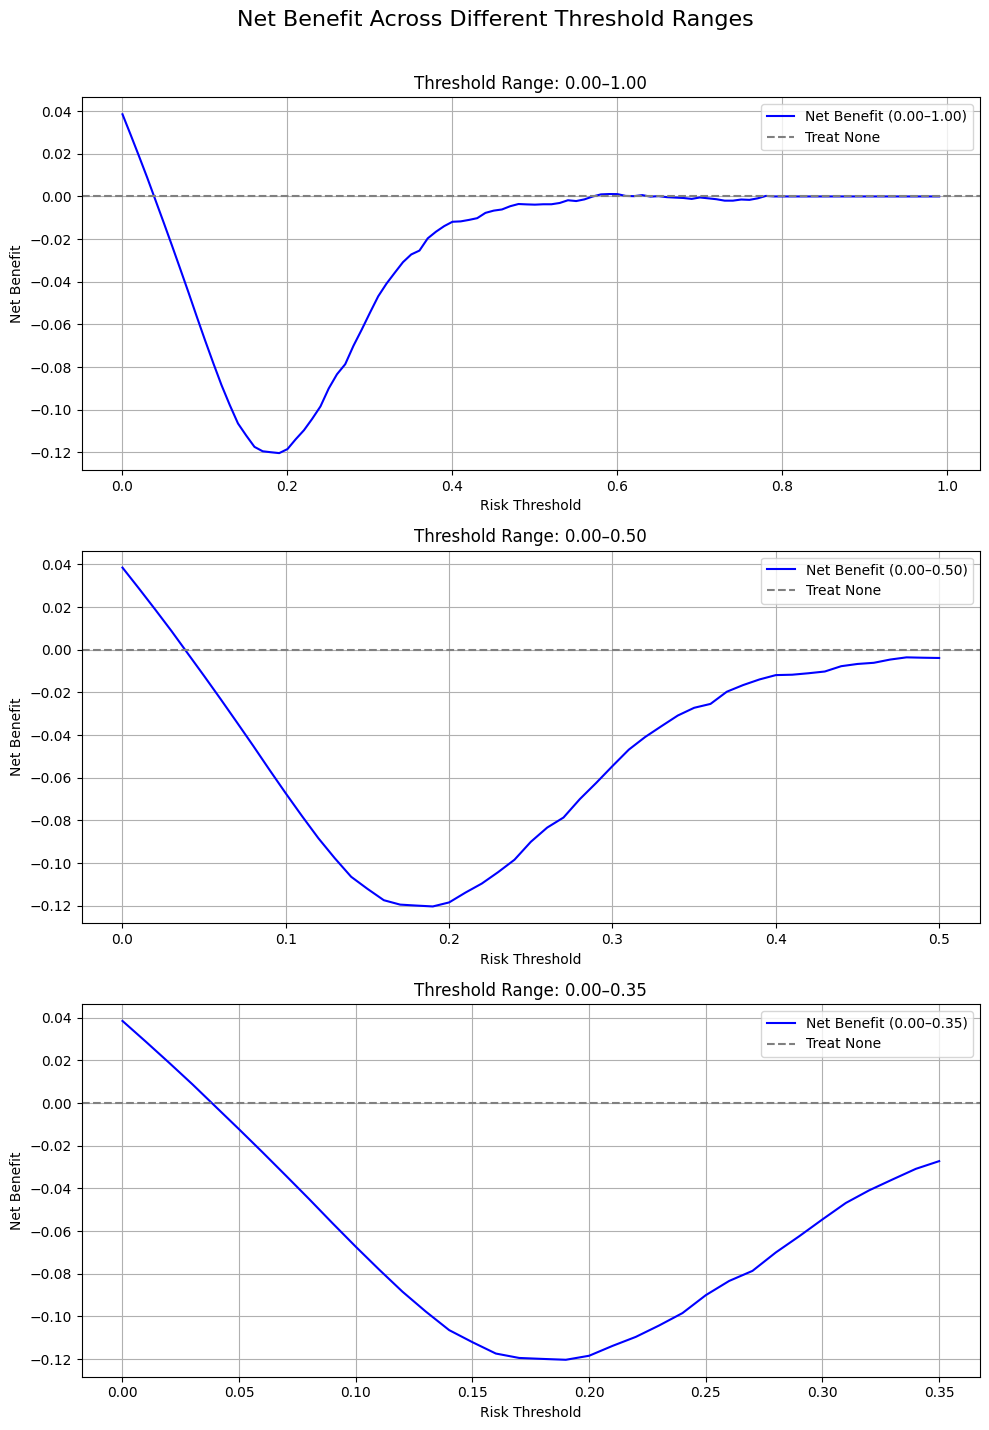

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Load data
df = pd.read_csv('/content/drive/Shared drives/ABCD_Model/LSTM/LSTM_no_demos_all_subject_predictions.csv')
y_true = df['true_label'].values
y_prob = df['predicted_prob'].values
prevalence = np.mean(y_true)

# Function to compute net benefit over thresholds
def compute_net_benefit(thresholds, y_true, y_prob, prevalence):
    net_benefits = []
    for pt in thresholds:
        w = pt / (1 - pt) if pt < 1 else np.inf
        y_pred = (y_prob >= pt).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        net_benefit = (sensitivity * prevalence) - ((1 - specificity) * (1 - prevalence) * w)
        net_benefits.append(net_benefit)
    return thresholds, net_benefits

# Threshold ranges
threshold_ranges = {
    '0.00–1.00': np.arange(0.00, 1.01, 0.01),
    '0.00–0.50': np.arange(0.00, 0.51, 0.01),
    '0.00–0.35': np.arange(0.00, 0.36, 0.01)
}

# Plot each separately
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=False)
fig.suptitle('Net Benefit Across Different Threshold Ranges', fontsize=16)

for ax, (label, thresholds) in zip(axes, threshold_ranges.items()):
    x_vals, y_vals = compute_net_benefit(thresholds, y_true, y_prob, prevalence)
    ax.plot(x_vals, y_vals, color='blue', label=f'Net Benefit ({label})')
    ax.axhline(0, color='gray', linestyle='--', label='Treat None')
    ax.set_title(f'Threshold Range: {label}')
    ax.set_xlabel('Risk Threshold')
    ax.set_ylabel('Net Benefit')
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
